# Troubleshoot too-good ML results with no game features

In [1]:
## Startup:

import synapseclient
from synapseclient import Project, Folder, File
import pandas as pd
import json
import pickle
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np
import seaborn as sns
import os
from numpy import nan
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import ranksums
%load_ext autoreload
%autoreload 2
%matplotlib inline  


## set options ##

sns.set(style="darkgrid", color_codes=True, font_scale=1.5)

# so i can see all rows of dfs
pd.set_option('display.max_columns', 500)

# so that i can print as many lines as i want
np.set_printoptions(threshold='nan') 

## import my memorytools module ##

import memorytools as mt


# Load up the memory & demographic data:

# initialize environment:
synuser = os.environ['SYNAPSE_USER']
synpass = os.environ['SYNAPSE_PASS']
mt.loadSynapseRecordsFromScratch = False
syn, memory, memorysyn, filePaths, demographics, demosyn, data = mt.create_memory_environment(synuser, synpass)
data = mt.filter_data_for_popular_phones(data)

# pull out features from games:
fromFile = True#False
toSave = False#True
data = mt.add_memory_game_features_to_data(filePaths, data, fromFile = fromFile, toSave=toSave, outFileName='memory_data_with_features.p')

# add memory composite features:
data = mt.add_composite_features_to_data(data)


from sklearn import linear_model
import sklearn
import sklearn.linear_model
import sklearn.cross_validation
import sklearn.tree
import sklearn.ensemble
import numpy as np
from sklearn.utils.validation import check_consistent_length, _num_samples
import sklearn.preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# load feature categories
fcats = mt.define_feature_categories()


Welcome, Matthew Oberhardt!
(phones are now filtered for only the most popular ones)
memory features loaded from file: memory_data_with_features.p (input data was ignored)
Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds
Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds


In [57]:
from memorytools import *
agecutoff = 45

# Works too well here:

['hasParkinsons', 'age', 'education', 'phoneInfo']
Features converted to numbers:

['phoneInfo', 'education']
dropped 19 rows to remove all nas from data
na rows have been dropped (if there were any)


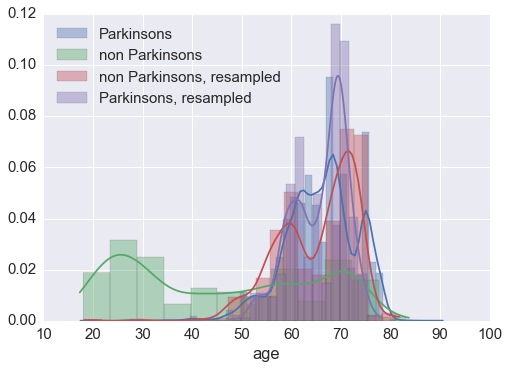

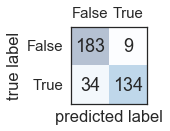

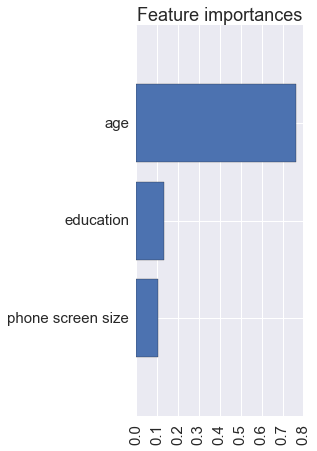

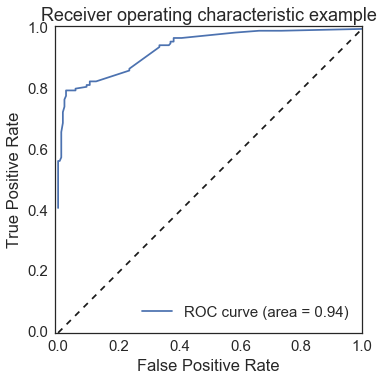



ranksum pval for dist. resampling = 0.138760667249
ranksum pval for sample balanced = 0.496525521206


num actual positives = 600
num actual negatives = 600


###### performance #######
precision: 0.937062937063
recall: 0.797619047619
F1: 0.861736334405
training accuracy: 0.913095238095
test accuracy: 0.880555555556
random accuracy would be 0.5
##########################


[u'age' u'education' u'phoneInfo']


In [95]:
# Run without any of the in-game features
#features = fcats['game'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features =                  ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features.remove('smartphone')
features.remove('gender')
print features
MLexcludecols = []
labelcol = 'hasParkinsons'
outs = mt.build_ML_model_age_corrected_and_samplebalanced(data, features, labelcol, toPlot=[0,0,1,1,1,1], toPrint=True, MLexcludecols=MLexcludecols)    
mod, features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred, y_pred_proba, fdf = outs
print X_names

# Hypothesis: random forest is using ages (& other) as identifiers, since there are repeated vals per user
    
    

## 1. randomize the hasParkinsons labels

['hasParkinsons', 'age', 'education', 'phoneInfo']
  hasParkinsons  age
0         False   43
1         False   43
2         False   73
3         False   73
4         False   73
  hasParkinsons  age
0         False   43
1          True   43
2          True   73
3          True   73
4          True   73
Features converted to numbers:

['phoneInfo', 'education']
dropped 19 rows to remove all nas from data
na rows have been dropped (if there were any)


ranksum pval for dist. resampling = 1.60657531783e-05
ranksum pval for sample balanced = 0.0329908108183


num actual positives = 600
num actual negatives = 600


###### performance #######
precision: 0.466666666667
recall: 1.0
F1: 0.636363636364
training accuracy: 0.514285714286
test accuracy: 0.466666666667
random accuracy would be 0.5
##########################


[u'phoneInfo']
run on all data, after removing young folks:
removing the young folks:
(7835, 4)
(6719, 4)
na rows have been dropped (if there were any)


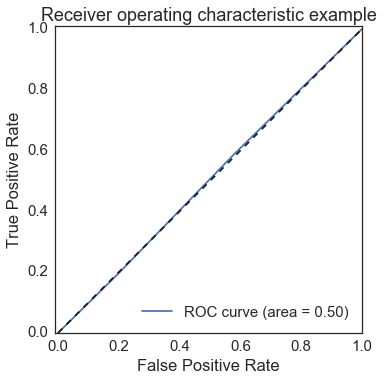

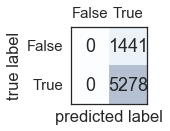

num actual positives = 5278
num actual negatives = 1441


###### performance #######
precision: 0.785533561542
recall: 1.0
F1: 0.879886638326
##########################


shape of X is:  (6719, 1)


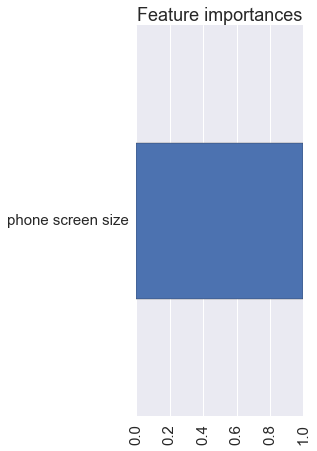

In [86]:
# Run without any of the in-game features
#features = fcats['game'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features =                  ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features.remove('smartphone')
features.remove('gender')
print features
MLexcludecols = ['age', 'education']
labelcol = 'hasParkinsons'

# randomly shuffle the hasParkinsons column:
data2 = data.copy()
datajunk = data.copy()
datajunk.index = np.random.permutation(datajunk.index)
data2['hasParkinsons'] = datajunk['hasParkinsons']
print data[['hasParkinsons','age']].head(5)
print data2[['hasParkinsons','age']].head(5)

outs = mt.build_ML_model_age_corrected_and_samplebalanced(data2, features, labelcol, toPlot=[0,0,0,0,0,0], toPrint=True, MLexcludecols=MLexcludecols)    
mod, features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred, y_pred_proba, fdf = outs
print X_names


# try running on all data:
print 'run on all data, after removing young folks:'
print 'removing the young folks:'

print fdf.shape
fdf = fdf[fdf['age']>agecutoff]
print fdf.shape


features_df, X_all, y_all, _X_names, _y_name, _X_train, _X_test, _y_train, _y_test = mt.prep_memory_features_for_machine_learning(fdf, features, labelcol, convert_features_to_nums=False, toStandardScale=False)

# shuffle vals:
#np.random.shuffle(X_all)


y_pred_proba_all = mod.predict_proba(X_all)[:,1]
y_pred_all = mod.predict(X_all)

mt.plot_roc_curve(y_all, y_pred_proba_all)
mt.render_confusion_matrix(y_all, y_pred_all)
mt.plot_feature_importances_randforest(mod, X_names)
len(X_all)
#print y_pred_proba_all

# print:
precision = sklearn.metrics.precision_score(y_true=y_all, y_pred=y_pred_all)
recall = sklearn.metrics.recall_score(y_true=y_all, y_pred=y_pred_all)
F1 = sklearn.metrics.f1_score(y_true=y_all, y_pred=y_pred_all)
print 'num actual positives = %s' % sum(y_all)
print 'num actual negatives = %s' % (len(y_all) - sum(y_all))
print '\n'
print '###### performance #######'
print 'precision:', precision
print 'recall:', recall
print 'F1:', F1
print '##########################'
print '\n'


print 'shape of X is: ', X_all.shape

## 2. take mean (later - for now, a single sample) of all features for each patient to remove duplicate entries

['hasParkinsons', 'age', 'education', 'phoneInfo']
Features converted to numbers:

['phoneInfo', 'education']
dropped 0 rows to remove all nas from data
na rows have been dropped (if there were any)


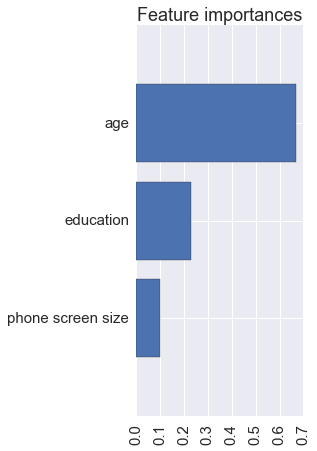

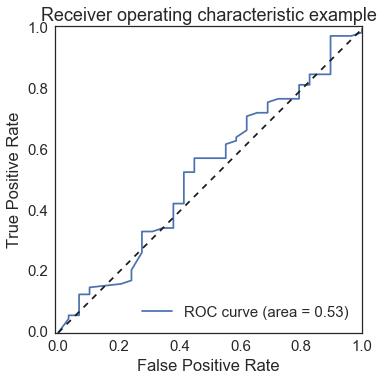



ranksum pval for dist. resampling = 0.0987218888005
ranksum pval for sample balanced = 5.66960540922e-05


num actual positives = 281
num actual negatives = 103


###### performance #######
precision: 0.785533561542
recall: 1.0
F1: 0.879886638326
training accuracy: 0.913095238095
test accuracy: 0.880555555556
random accuracy would be 0.5
##########################




In [97]:
# take only one record per patient to remove duplicates. mean is better, but that's later..

features =                  ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features.remove('smartphone')
features.remove('gender')
print features
MLexcludecols = []
labelcol = 'hasParkinsons'

# redo data so i take 1 sample of each patient.
grouped = data.groupby('healthCode')
data2 = grouped.apply(lambda x: x.sample(n=1))
# remove young patients:
data2 = data2[data2['age']>agecutoff]
#outs = mt.build_ML_model_age_corrected_and_samplebalanced(data2, features, labelcol, toPlot=[0,0,0,0,0,0], toPrint=True, MLexcludecols=MLexcludecols)    
######################################################################
######################################################################

#df = data
convert_features_to_nums=False
toStandardScale=False
toPlot=[0,0,0,0,1,1]
toPrint=True


distcol = 'age'
splitcol = 'hasParkinsons'
nbins = 10
nResamples = 600

# build features dataframe:
#fdf = data[features]
fdf = data2[features]
fdf = convert_features_to_numbers(fdf)

# drop nas:
len1 = len(fdf)
fdf = fdf.dropna()
len2 = len(fdf)
print 'dropped %s rows to remove all nas from data' % (len1 - len2)



## resample non-Park to same age distribution as Parkinsons:
#splitVal_resample = False
#splitVal_guide = True
#
#df_resampled, df_guide, df_resample = resample_to_match_distribution(fdf, distcol, splitcol, splitVal_resample, splitVal_guide, nbins, nResamples)
#df_resampled_np = df_resampled
#df_Parkinsons = df_guide
#df_np = df_resample
#
## test pval first set:
#a = df_resampled[distcol].dropna().values
#b = df_guide[distcol].dropna().values
#p1 = ranksums(a, b)
#
## resample Park to the resampled non-Park for sample balancing:
#fdf2 = df_resampled_np.append(df_Parkinsons)
#
#splitVal_resample = True
#splitVal_guide = False
#df_resampled, df_guide, df_resample = resample_to_match_distribution(fdf2, distcol, splitcol, splitVal_resample, splitVal_guide, nbins, nResamples)
#df_resampled_Park = df_resampled
#
## test pval 2nd set:
#a = df_resampled_np[distcol].dropna().values
#b = df_resampled_Park[distcol].dropna().values
#p2 = ranksums(a, b)


### Redo machine learning with these sets:
#df = df_resampled_np.append(df_resampled_Park)
df = fdf

# remove cols to exclude from ML (but that were needed for processing)
if len(MLexcludecols) > 0:
    for col in MLexcludecols:
        df = df.drop(col, axis=1)
        features.remove(col)

######### Machine learning #########

features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test = prep_memory_features_for_machine_learning(df, features, labelcol, convert_features_to_nums=False, toStandardScale=False)

# create model:
mod = RandomForestClassifier(n_estimators=100)
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
mod.fit(X_train, y_train)

# Probabilities predicted for test set to be in + class:
y_pred_proba = mod.predict_proba(X_test)[:,1]

#  Confusion matrix:
y_pred = mod.predict(X_test)
#    sklearn.metrics.roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)


######### Plotting & outputs #########

if toPlot[0] == 1:

    # plot zeroth set:
    plt.figure()
    sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons')
    sns.distplot(df_np[distcol].dropna(), label='non Parkinsons')
    plt.legend(loc=2)
    plt.show()

if toPlot[1] == 1:
    # plot first set:
    plt.figure()
    sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons')
    sns.distplot(df_np[distcol].dropna(), label='non Parkinsons')
    sns.distplot(df_resampled_np[distcol].dropna(), label='non Parkinsons, resampled')
    plt.legend(loc=2)
    plt.show()

if toPlot[2] == 1:
# plot second set:
    plt.figure()
    sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons')
    sns.distplot(df_np[distcol].dropna(), label='non Parkinsons')
    sns.distplot(df_resampled_np[distcol].dropna(), label='non Parkinsons, resampled')
    sns.distplot(df_resampled_Park[distcol].dropna(), label='Parkinsons, resampled')
    plt.legend(loc=2)
    plt.show()

if toPlot[3] == 1:
    render_confusion_matrix(y_test, y_pred)

if toPlot[4] == 1:
    plot_feature_importances_randforest(mod, X_names)

if toPlot[5] == 1:
    plot_roc_curve(y_test, y_pred_proba)

if toPrint == True:
    # test pvals 1st and 2nd set:
    print '\n'
    print 'ranksum pval for dist. resampling = %s' % p1[1]
    print 'ranksum pval for sample balanced = %s' % p2[1]
    print '\n'
    print 'num actual positives = %s' % sum(y)
    print 'num actual negatives = %s' % (len(y) - sum(y))
    print '\n'
    print '###### performance #######'
    print 'precision:', precision
    print 'recall:', recall
    print 'F1:', F1
    print 'training accuracy:', train_acc
    print 'test accuracy:', test_acc
    print 'random accuracy would be %s' % rand_acc
    print '##########################'
    print '\n'

######################################################################
######################################################################













## good, doesn't work. Now, add back in game score:

['game_score', 'hasParkinsons', 'age', 'education', 'phoneInfo']
Features converted to numbers:

['phoneInfo', 'education']
dropped 0 rows to remove all nas from data
na rows have been dropped (if there were any)


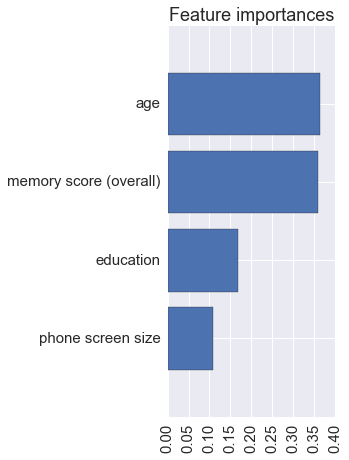

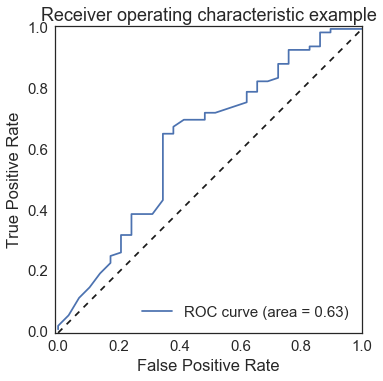



ranksum pval for dist. resampling = 0.0987218888005
ranksum pval for sample balanced = 5.66960540922e-05


num actual positives = 281
num actual negatives = 103


###### performance #######
precision: 0.785533561542
recall: 1.0
F1: 0.879886638326
training accuracy: 0.913095238095
test accuracy: 0.880555555556
random accuracy would be 0.5
##########################




In [98]:
# take only one record per patient to remove duplicates. mean is better, but that's later..

features = ['game_score'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features.remove('smartphone')
features.remove('gender')
print features
MLexcludecols = []
labelcol = 'hasParkinsons'

# redo data so i take 1 sample of each patient.
grouped = data.groupby('healthCode')
data2 = grouped.apply(lambda x: x.sample(n=1))
# remove young patients:
data2 = data2[data2['age']>agecutoff]
#outs = mt.build_ML_model_age_corrected_and_samplebalanced(data2, features, labelcol, toPlot=[0,0,0,0,0,0], toPrint=True, MLexcludecols=MLexcludecols)    
######################################################################
######################################################################

#df = data
convert_features_to_nums=False
toStandardScale=False
toPlot=[0,0,0,0,1,1]
toPrint=True


distcol = 'age'
splitcol = 'hasParkinsons'
nbins = 10
nResamples = 600

# build features dataframe:
#fdf = data[features]
fdf = data2[features]
fdf = convert_features_to_numbers(fdf)

# drop nas:
len1 = len(fdf)
fdf = fdf.dropna()
len2 = len(fdf)
print 'dropped %s rows to remove all nas from data' % (len1 - len2)



## resample non-Park to same age distribution as Parkinsons:
#splitVal_resample = False
#splitVal_guide = True
#
#df_resampled, df_guide, df_resample = resample_to_match_distribution(fdf, distcol, splitcol, splitVal_resample, splitVal_guide, nbins, nResamples)
#df_resampled_np = df_resampled
#df_Parkinsons = df_guide
#df_np = df_resample
#
## test pval first set:
#a = df_resampled[distcol].dropna().values
#b = df_guide[distcol].dropna().values
#p1 = ranksums(a, b)
#
## resample Park to the resampled non-Park for sample balancing:
#fdf2 = df_resampled_np.append(df_Parkinsons)
#
#splitVal_resample = True
#splitVal_guide = False
#df_resampled, df_guide, df_resample = resample_to_match_distribution(fdf2, distcol, splitcol, splitVal_resample, splitVal_guide, nbins, nResamples)
#df_resampled_Park = df_resampled
#
## test pval 2nd set:
#a = df_resampled_np[distcol].dropna().values
#b = df_resampled_Park[distcol].dropna().values
#p2 = ranksums(a, b)


### Redo machine learning with these sets:
#df = df_resampled_np.append(df_resampled_Park)
df = fdf

# remove cols to exclude from ML (but that were needed for processing)
if len(MLexcludecols) > 0:
    for col in MLexcludecols:
        df = df.drop(col, axis=1)
        features.remove(col)

######### Machine learning #########

features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test = prep_memory_features_for_machine_learning(df, features, labelcol, convert_features_to_nums=False, toStandardScale=False)

# create model:
mod = RandomForestClassifier(n_estimators=100)
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
mod.fit(X_train, y_train)

# Probabilities predicted for test set to be in + class:
y_pred_proba = mod.predict_proba(X_test)[:,1]

#  Confusion matrix:
y_pred = mod.predict(X_test)
#    sklearn.metrics.roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)


######### Plotting & outputs #########

if toPlot[0] == 1:

    # plot zeroth set:
    plt.figure()
    sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons')
    sns.distplot(df_np[distcol].dropna(), label='non Parkinsons')
    plt.legend(loc=2)
    plt.show()

if toPlot[1] == 1:
    # plot first set:
    plt.figure()
    sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons')
    sns.distplot(df_np[distcol].dropna(), label='non Parkinsons')
    sns.distplot(df_resampled_np[distcol].dropna(), label='non Parkinsons, resampled')
    plt.legend(loc=2)
    plt.show()

if toPlot[2] == 1:
# plot second set:
    plt.figure()
    sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons')
    sns.distplot(df_np[distcol].dropna(), label='non Parkinsons')
    sns.distplot(df_resampled_np[distcol].dropna(), label='non Parkinsons, resampled')
    sns.distplot(df_resampled_Park[distcol].dropna(), label='Parkinsons, resampled')
    plt.legend(loc=2)
    plt.show()

if toPlot[3] == 1:
    render_confusion_matrix(y_test, y_pred)

if toPlot[4] == 1:
    plot_feature_importances_randforest(mod, X_names)

if toPlot[5] == 1:
    plot_roc_curve(y_test, y_pred_proba)

if toPrint == True:
    # test pvals 1st and 2nd set:
    print '\n'
    print 'ranksum pval for dist. resampling = %s' % p1[1]
    print 'ranksum pval for sample balanced = %s' % p2[1]
    print '\n'
    print 'num actual positives = %s' % sum(y)
    print 'num actual negatives = %s' % (len(y) - sum(y))
    print '\n'
    print '###### performance #######'
    print 'precision:', precision
    print 'recall:', recall
    print 'F1:', F1
    print 'training accuracy:', train_acc
    print 'test accuracy:', test_acc
    print 'random accuracy would be %s' % rand_acc
    print '##########################'
    print '\n'

######################################################################
######################################################################







## Now add in other memory game components and see how we do

['game_numFails', 'game_score', 'game_numGames', '9_numsuccesses', '9_numunsuccesses', '9_meandist', '9_successful', '9_gamescore', '9_latency', '9_firstdist', '9_meanDt', '9_meansuccessfuldist', '16_firstdist', '16_meandist', '16_numsuccesses', '16_gamescore', '16_latency', '16_numunsuccesses', '16_successful', '16_meanDt', '16_meansuccessfuldist', 'played_game4', 'hasParkinsons', 'age', 'education', 'phoneInfo']
Features converted to numbers:

['phoneInfo', 'education']
dropped 23 rows to remove all nas from data
na rows have been dropped (if there were any)


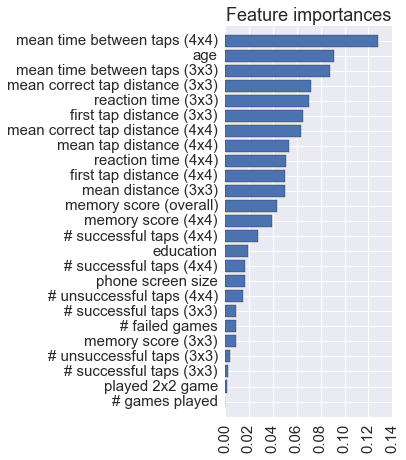

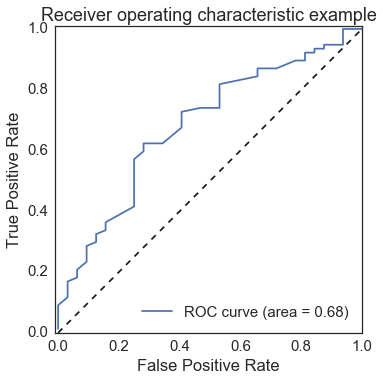



ranksum pval for dist. resampling = 0.0987218888005
ranksum pval for sample balanced = 5.66960540922e-05


num actual positives = 261
num actual negatives = 100


###### performance #######
precision: 0.785533561542
recall: 1.0
F1: 0.879886638326
training accuracy: 0.913095238095
test accuracy: 0.880555555556
random accuracy would be 0.5
##########################




In [101]:
# take only one record per patient to remove duplicates. mean is better, but that's later..

#features = ['9_meanDt'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features = fcats['game'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features.remove('smartphone')
features.remove('gender')
print features
MLexcludecols = []
labelcol = 'hasParkinsons'

# redo data so i take 1 sample of each patient.
grouped = data.groupby('healthCode')
data2 = grouped.apply(lambda x: x.sample(n=1))
# remove young patients:
data2 = data2[data2['age']>agecutoff]
#outs = mt.build_ML_model_age_corrected_and_samplebalanced(data2, features, labelcol, toPlot=[0,0,0,0,0,0], toPrint=True, MLexcludecols=MLexcludecols)    
######################################################################
######################################################################

#df = data
convert_features_to_nums=False
toStandardScale=False
toPlot=[0,0,0,0,1,1]
toPrint=True


distcol = 'age'
splitcol = 'hasParkinsons'
nbins = 10
nResamples = 600

# build features dataframe:
#fdf = data[features]
fdf = data2[features]
fdf = convert_features_to_numbers(fdf)

# drop nas:
len1 = len(fdf)
fdf = fdf.dropna()
len2 = len(fdf)
print 'dropped %s rows to remove all nas from data' % (len1 - len2)



## resample non-Park to same age distribution as Parkinsons:
#splitVal_resample = False
#splitVal_guide = True
#
#df_resampled, df_guide, df_resample = resample_to_match_distribution(fdf, distcol, splitcol, splitVal_resample, splitVal_guide, nbins, nResamples)
#df_resampled_np = df_resampled
#df_Parkinsons = df_guide
#df_np = df_resample
#
## test pval first set:
#a = df_resampled[distcol].dropna().values
#b = df_guide[distcol].dropna().values
#p1 = ranksums(a, b)
#
## resample Park to the resampled non-Park for sample balancing:
#fdf2 = df_resampled_np.append(df_Parkinsons)
#
#splitVal_resample = True
#splitVal_guide = False
#df_resampled, df_guide, df_resample = resample_to_match_distribution(fdf2, distcol, splitcol, splitVal_resample, splitVal_guide, nbins, nResamples)
#df_resampled_Park = df_resampled
#
## test pval 2nd set:
#a = df_resampled_np[distcol].dropna().values
#b = df_resampled_Park[distcol].dropna().values
#p2 = ranksums(a, b)


### Redo machine learning with these sets:
#df = df_resampled_np.append(df_resampled_Park)
df = fdf

# remove cols to exclude from ML (but that were needed for processing)
if len(MLexcludecols) > 0:
    for col in MLexcludecols:
        df = df.drop(col, axis=1)
        features.remove(col)

######### Machine learning #########

features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test = prep_memory_features_for_machine_learning(df, features, labelcol, convert_features_to_nums=False, toStandardScale=False)

# create model:
mod = RandomForestClassifier(n_estimators=100)
#lr = linear_model.LogisticRegression(penalty='l1', C=0.1) # with regularization
mod.fit(X_train, y_train)

# Probabilities predicted for test set to be in + class:
y_pred_proba = mod.predict_proba(X_test)[:,1]

#  Confusion matrix:
y_pred = mod.predict(X_test)
#    sklearn.metrics.roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)


######### Plotting & outputs #########

if toPlot[0] == 1:

    # plot zeroth set:
    plt.figure()
    sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons')
    sns.distplot(df_np[distcol].dropna(), label='non Parkinsons')
    plt.legend(loc=2)
    plt.show()

if toPlot[1] == 1:
    # plot first set:
    plt.figure()
    sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons')
    sns.distplot(df_np[distcol].dropna(), label='non Parkinsons')
    sns.distplot(df_resampled_np[distcol].dropna(), label='non Parkinsons, resampled')
    plt.legend(loc=2)
    plt.show()

if toPlot[2] == 1:
# plot second set:
    plt.figure()
    sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons')
    sns.distplot(df_np[distcol].dropna(), label='non Parkinsons')
    sns.distplot(df_resampled_np[distcol].dropna(), label='non Parkinsons, resampled')
    sns.distplot(df_resampled_Park[distcol].dropna(), label='Parkinsons, resampled')
    plt.legend(loc=2)
    plt.show()

if toPlot[3] == 1:
    render_confusion_matrix(y_test, y_pred)

if toPlot[4] == 1:
    plot_feature_importances_randforest(mod, X_names)

if toPlot[5] == 1:
    plot_roc_curve(y_test, y_pred_proba)

if toPrint == True:
    # test pvals 1st and 2nd set:
    print '\n'
    print 'ranksum pval for dist. resampling = %s' % p1[1]
    print 'ranksum pval for sample balanced = %s' % p2[1]
    print '\n'
    print 'num actual positives = %s' % sum(y)
    print 'num actual negatives = %s' % (len(y) - sum(y))
    print '\n'
    print '###### performance #######'
    print 'precision:', precision
    print 'recall:', recall
    print 'F1:', F1
    print 'training accuracy:', train_acc
    print 'test accuracy:', test_acc
    print 'random accuracy would be %s' % rand_acc
    print '##########################'
    print '\n'

######################################################################
######################################################################






In [ ]:
# that worked..

## Run same test as above with simplified code (one sample per patient, all features):

['game_numFails', 'game_score', 'game_numGames', '9_numsuccesses', '9_numunsuccesses', '9_meandist', '9_successful', '9_gamescore', '9_latency', '9_firstdist', '9_meanDt', '9_meansuccessfuldist', '16_firstdist', '16_meandist', '16_numsuccesses', '16_gamescore', '16_latency', '16_numunsuccesses', '16_successful', '16_meanDt', '16_meansuccessfuldist', 'played_game4', 'hasParkinsons', 'age', 'education', 'phoneInfo']
Features converted to numbers:

['phoneInfo', 'education']
dropped 27 rows to remove all nas from data
na rows have been dropped (if there were any)


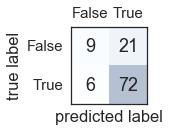

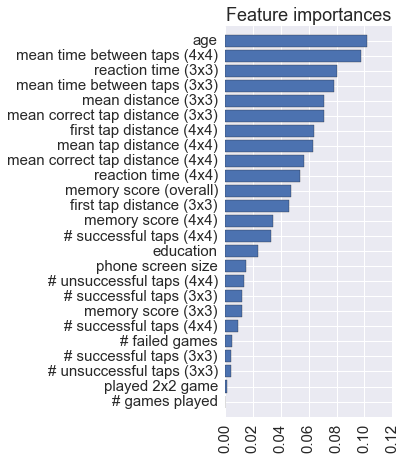

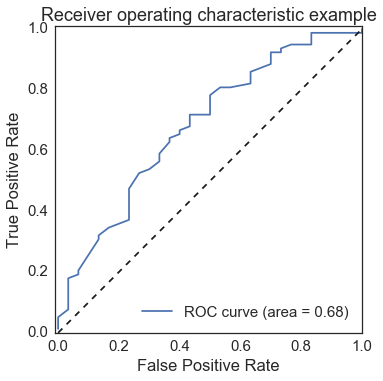



num actual positives = 257
num actual negatives = 100


###### performance #######
precision: 0.774193548387
recall: 0.923076923077
F1: 0.842105263158
training accuracy: 1.0
test accuracy: 0.75
random accuracy would be 0.719887955182
##########################




In [114]:
# simplified code when not sample balancing:
# (with other memory features)

# take only one record per patient to remove duplicates. mean is better, but that's later..

features = fcats['game'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone']
features.remove('smartphone')
features.remove('gender')
print features
MLexcludecols = []
labelcol = 'hasParkinsons'

# redo data so i take 1 sample of each patient.
grouped = data.groupby('healthCode')
datasample = grouped.apply(lambda x: x.sample(n=1))
# remove young patients:
datasample = datasample[datasample['age']>agecutoff]

outs = mt.build_ML_model(datasample, features, labelcol=labelcol, toPlot=[1,1,1], toPrint=True, MLexcludecols=MLexcludecols)
model, fdf, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred, y_pred_proba = outs   




## mean values per patient, all features:

Features converted to numbers:

['phoneInfo', 'education']
dropped 249 rows to remove all nas from data
na rows have been dropped (if there were any)


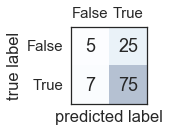

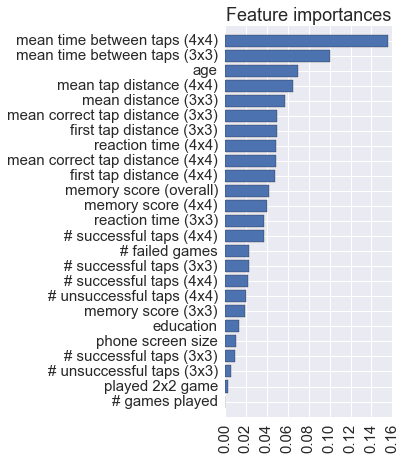

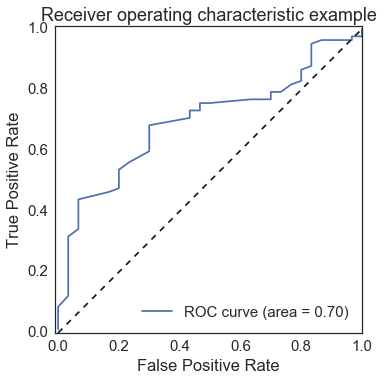



num actual positives = 271.0
num actual negatives = 101.0


###### performance #######
precision: 0.75
recall: 0.914634146341
F1: 0.824175824176
training accuracy: 1.0
test accuracy: 0.714285714286
random accuracy would be 0.728494623656
##########################




In [156]:
# simplified code when not sample balancing:
# (with other memory features)

# take only one record per patient to remove duplicates. mean is better, but that's later..

features = fcats['game'] + ['hasParkinsons'] + fcats['demographic'] + fcats['phone'] + ['healthCode']
features.remove('smartphone')
features.remove('gender')
#print features
featureToMean = ['healthCode'] # don't need to also exclude - this step takes care of that too.
MLexcludecols = []
labelcol = 'hasParkinsons'

# redo data so i take 1 sample of each patient.
#grouped = data.groupby('healthCode')
#datasample = grouped.apply(lambda x: x.sample(n=1))
# remove young patients:
datasample = data[data['age']>50]

outs = mt.build_ML_model(datasample, features, labelcol=labelcol, toPlot=[1,1,1], toPrint=True, MLexcludecols=MLexcludecols, modelType='randomforest', featureToMean=featureToMean)
model, fdf, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred, y_pred_proba = outs   





## mean values per patient, only demographic features

Features converted to numbers:

['phoneInfo', 'education']
dropped 0 rows to remove all nas from data
na rows have been dropped (if there were any)


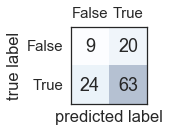

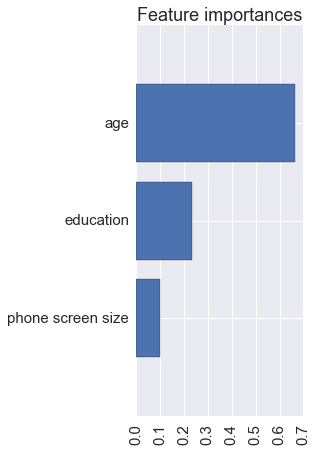

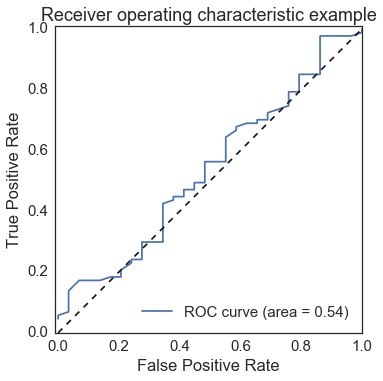



num actual positives = 281.0
num actual negatives = 103.0


###### performance #######
precision: 0.759036144578
recall: 0.724137931034
F1: 0.741176470588
training accuracy: 0.899253731343
test accuracy: 0.620689655172
random accuracy would be 0.731770833333
##########################




In [157]:
# simplified code when not sample balancing:
# (with other memory features)

# take only one record per patient to remove duplicates. mean is better, but that's later..

features = ['hasParkinsons'] + fcats['demographic'] + fcats['phone'] + ['healthCode']
features.remove('smartphone')
features.remove('gender')
#print features
featureToMean = ['healthCode'] # don't need to also exclude - this step takes care of that too.
MLexcludecols = []
labelcol = 'hasParkinsons'

# redo data so i take 1 sample of each patient.
#grouped = data.groupby('healthCode')
#datasample = grouped.apply(lambda x: x.sample(n=1))

# remove young patients:
datasample = data[data['age']>50]

outs = mt.build_ML_model(datasample, features, labelcol=labelcol, toPlot=[1,1,1], toPrint=True, MLexcludecols=MLexcludecols, modelType='randomforest', featureToMean=featureToMean)
model, fdf, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred, y_pred_proba = outs   




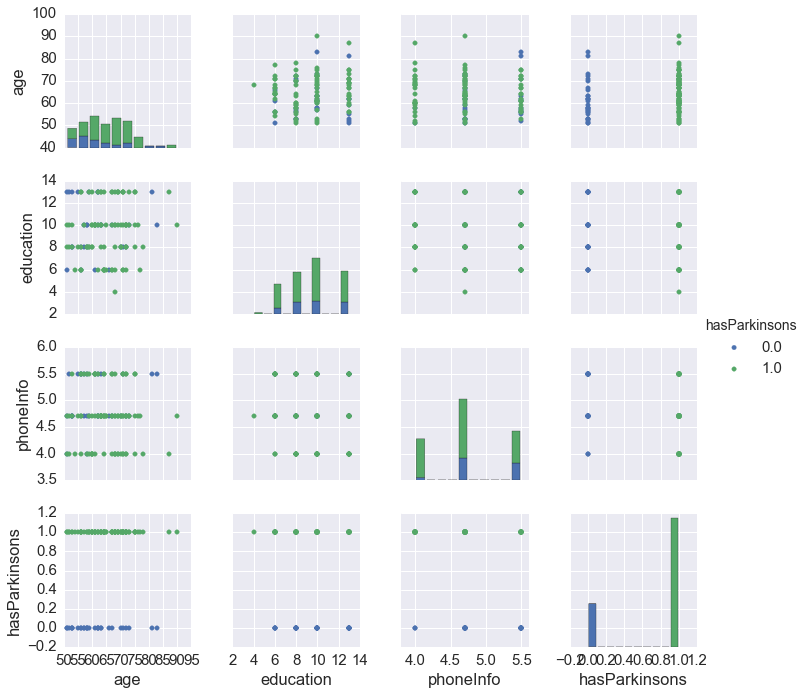

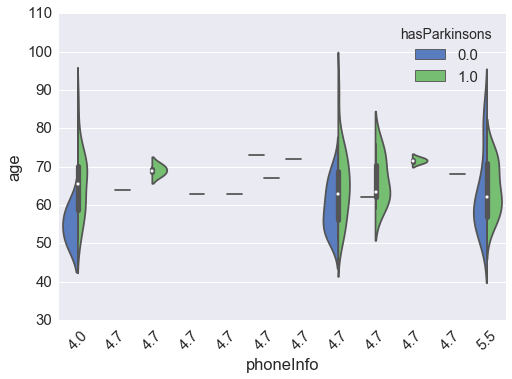

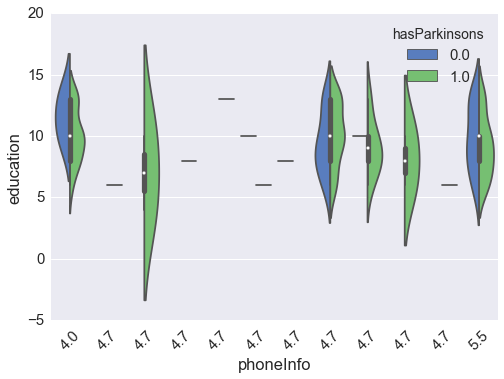

In [158]:
# visualize the feature distributions:
dftest = pd.DataFrame()
for i, name in enumerate(X_names):
    dftest[name] = X_test[:,i]

dftest['hasParkinsons'] = y_test
features_df = dftest

g = sns.PairGrid(features_df, hue="hasParkinsons")
g = g.map_offdiag(plt.scatter)
g = g.map_diag(plt.hist)
g = g.add_legend()

yvar = 'hasParkinsons'
catvars = ['phoneInfo']
freqvars = ['age', 'education']
for freqvar in freqvars:
    for catvar in catvars:
        plt.figure()
        ax1 = sns.violinplot(x=catvar, y=freqvar, hue=yvar, data=features_df, palette="muted", split=True)    
        plt.xticks(rotation=45)

In [ ]:


mod, features_df, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred, y_pred_proba, fdf = outs
print X_names


# try running on all data:
print 'run on all data, after removing young folks:'
print 'removing the young folks:'
print fdf.shape
fdf = fdf[fdf['age']>agecutoff]
print fdf.shape


features_df, X_all, y_all, _X_names, _y_name, _X_train, _X_test, _y_train, _y_test = mt.prep_memory_features_for_machine_learning(fdf, features, labelcol, convert_features_to_nums=False, toStandardScale=False)

# shuffle vals:
#np.random.shuffle(X_all)


y_pred_proba_all = mod.predict_proba(X_all)[:,1]
y_pred_all = mod.predict(X_all)

mt.plot_roc_curve(y_all, y_pred_proba_all)
mt.render_confusion_matrix(y_all, y_pred_all)
mt.plot_feature_importances_randforest(mod, X_names)
len(X_all)
#print y_pred_proba_all

# print:
precision = sklearn.metrics.precision_score(y_true=y_all, y_pred=y_pred_all)
recall = sklearn.metrics.recall_score(y_true=y_all, y_pred=y_pred_all)
F1 = sklearn.metrics.f1_score(y_true=y_all, y_pred=y_pred_all)
print 'num actual positives = %s' % sum(y_all)
print 'num actual negatives = %s' % (len(y_all) - sum(y_all))
print '\n'
print '###### performance #######'
print 'precision:', precision
print 'recall:', recall
print 'F1:', F1
print '##########################'
print '\n'


print 'shape of X is: ', X_all.shape

In [ ]:
# todo: 
    
## Loop through different users and create ensemble of models


In [72]:
data2 = data.copy()

grouped = data2.groupby('healthCode')


In [78]:
grouped.groups
grouped.mean().head(2)

for healthCode, group in grouped:
    group = group.dropna(subset=features)
    newthing = group.mean()
    
    
    

(7854, 82)

## 3. try logistic regression (shouldn't have the same nonlinearity problems)

In [ ]:
4. add gaussian noise to the ages, in case individual 